# Лабораторная работа №2 по компьютерному зрению.   
**Выполнил:** Напылов Евгений, 381806-2

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
from math import exp
from IPython.display import Image # т.к. маркдаун картинки не хотят работать на гитхабе :(

In [2]:
# выводит 5 матриц
def print_res(array):
    shapes = array.shape
    for i in range(shapes[0]):
        print(f'm={i}; shape={(shapes[1], shapes[2])}\n{array[i]}')

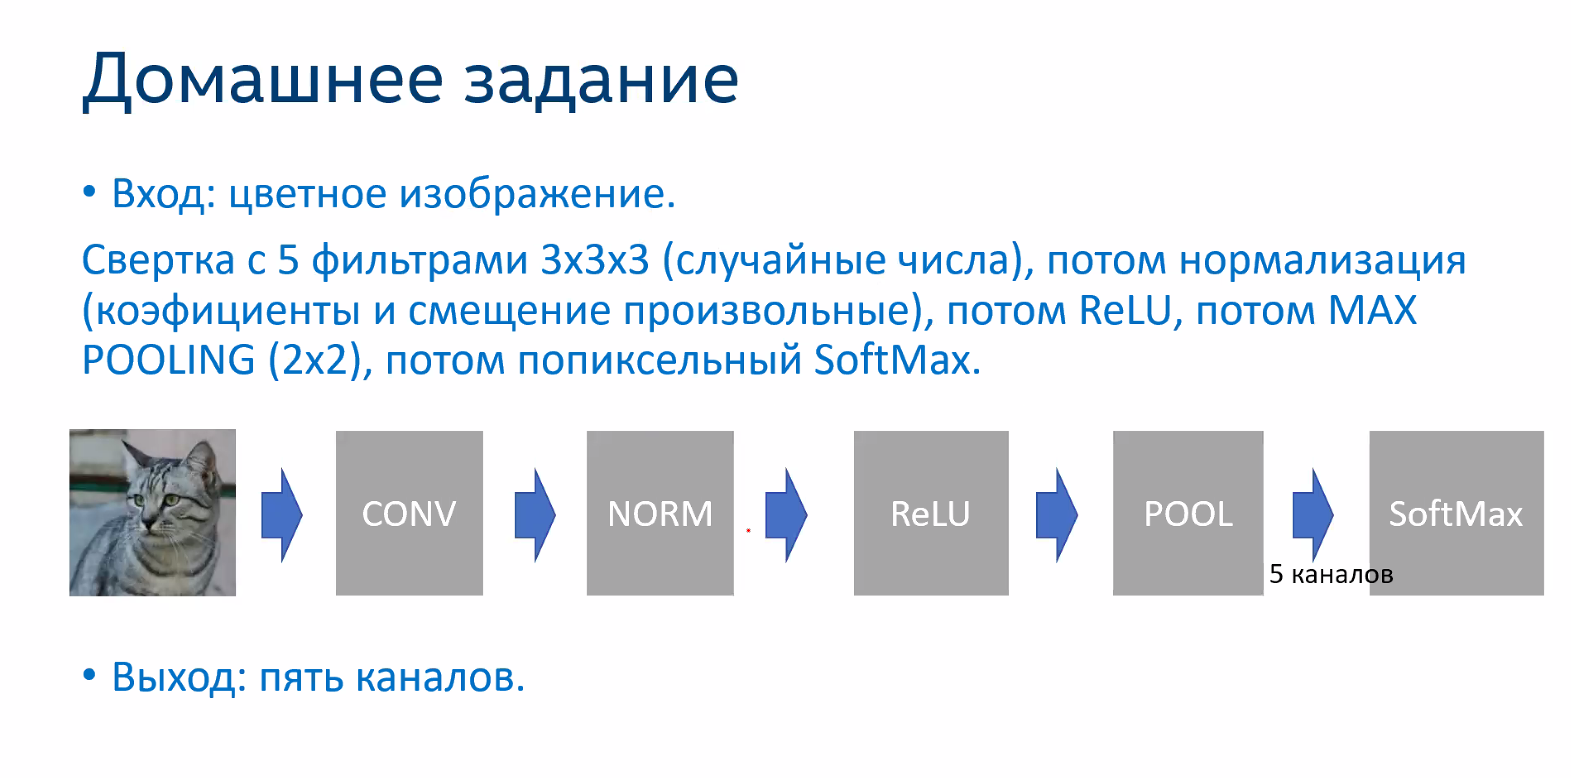

In [3]:
Image(filename="./img/cv_task_2.png")

## 0. Загрузка изображения

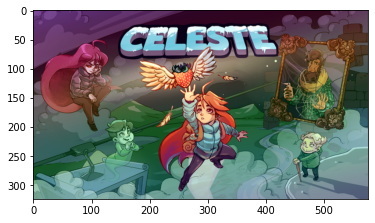

In [4]:
image = cv2.imread("./img/celeste.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

## 1. Свертка с 5 фильтрами 3х3х3 рандом   
Есть 5 фильтров 3х3х3. Каждый фильтр распознает какой-то признак на изображении.

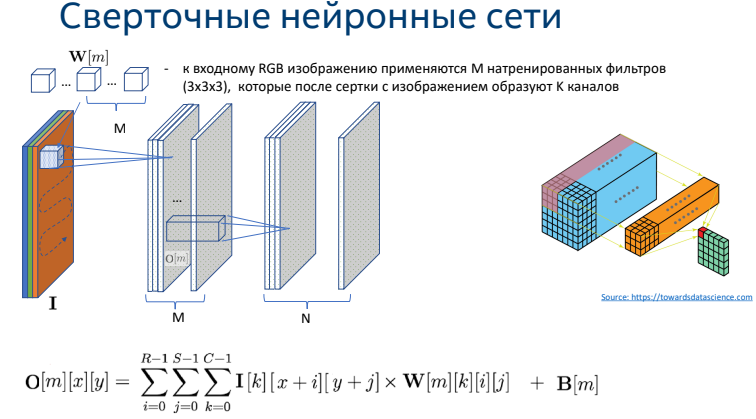

In [5]:
Image(filename="./img/svertka.png")

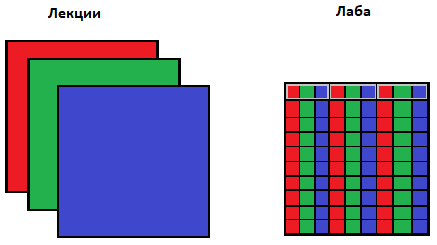

In [6]:
Image(filename="./img/compare.png")

5 фильтров 3х3х3 с рандомными коэффициентами:

In [7]:
M = 5
R = S = C = 3
W = np.random.rand(M, R, S, C)
W.shape

(5, 3, 3, 3)

In [8]:
w = image.shape[0]
h = image.shape[1]
w, h

(324, 576)

In [9]:
B = np.random.rand(M) # рандомные смещения для каждого фильтра

In [10]:
# при перемещении по окну в границах изображения можно выйти за границы и получить ошибку
# есть 2 варианта(которые я сразу вспомнил) это пофиксить: не полностью перемещаться или добить нулями
# выбрал добить нулями

def get_pixel_safe(img, w, h, x, y, r, s, c):
    xr = x + r
    ys = y + s
    # c в конце т.к. изображение хранится не в виде 3-х слоев-каналов, а в виде одного слоя с [r,g,b]
    return 0 if xr > w - 1 or ys > h - 1 else img[xr][ys][c]


def convolution(image, w, h, R, S, C, W, B, M):
    result = np.zeros((M, w, h)) # 5 каналов в результате
    for m in range(M):
        for x in range(w):
            for y in range(h):
                result[m][x][y] = B[m]
                for r in range(R):
                    for s in range(S):
                        for c in range(C):
                            result[m][x][y] += get_pixel_safe(image, w, h, x, y, r, s, c) * W[m][c][r][s]
    return result

In [11]:
result_conv = convolution(image, w, h, R, S, C, W, B, M)

In [12]:
result_conv.shape

(5, 324, 576)

In [13]:
print_res(result_conv)

m=0; shape=(324, 576)
[[1645.0456162  1703.48907034 1742.74159855 ... 1232.80831178
   791.50692641  357.34824142]
 [1747.18395325 1772.44637732 1776.14415169 ... 1236.29675019
   792.18710182  359.121009  ]
 [1772.0188533  1770.1467699  1768.71421769 ... 1237.89189683
   793.01701232  360.07411605]
 ...
 [2149.75819694 2150.63614804 2132.0939278  ... 1479.38683452
   935.9956236   495.112457  ]
 [1357.8556359  1358.35864243 1345.44124635 ...  924.88776005
   602.73505432  372.59303252]
 [ 474.73866428  474.73866428  470.34529461 ...  312.39163192
   211.09162623  106.35668724]]
m=1; shape=(324, 576)
[[1554.07061462 1618.09313882 1663.45613759 ... 1168.60784976
   810.91714407  375.36059223]
 [1675.82590562 1711.00288471 1721.79336145 ... 1170.47656661
   812.0227798   376.35872683]
 [1717.72547921 1716.29175085 1712.39189761 ... 1173.77242153
   811.67452588  377.34232304]
 ...
 [1992.71772115 1993.67754604 1982.75318139 ... 1417.52171823
   967.96086526  495.33807336]
 [1543.62592726

## 2. Нормализация
Получили огромные числа, с огромным разбросом. Такое сложно анализировать.    
Необходимо привести их в другой диапазон - около 0, чтобы отклонение было=1.

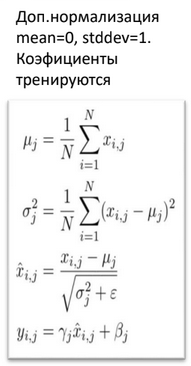

In [14]:
Image(filename="./img/norm.png")

In [15]:
def normalization(img_m, gamma, beta):
    # задача сделать avg~=0, var=1
    # img = 2nd array
    eps = 1e-6 # eps - защита от деления на 0
    # формулы простые, а numpy посчитает гораздо быстрее -> решил использовать numpy
    mu = np.mean(img_m, axis=0) # среднее
    var = np.var(img_m, axis=0) # дисперсия
    tmp = (img_m - mu) / np.sqrt(var + eps)
    res = gamma * tmp + beta
    return res

def normalization_all(img, gamma, beta):
    res = np.zeros(img.shape)
    for m in range(img.shape[0]):
        res[m] = normalization(img[m], gamma, beta)
    return res

In [16]:
 # гамма и бета тренируются, их начальные значения обычно берут 1 и 0. Без тренировки решил взять начальные
result_conv_norm = normalization_all(result_conv, gamma=1, beta=0)
for i in range(result_conv_norm.shape[0]):
    print(f"m={i}; mean={np.mean(result_conv_norm[i])}; var={np.var(result_conv_norm[i])}")
print()
print_res(result_conv_norm)

m=0; mean=1.1208836023650414e-16; var=0.9999999999970359
m=1; mean=-4.873406966804528e-17; var=0.9999999999966327
m=2; mean=-1.0721495326969961e-16; var=0.99999999999522
m=3; mean=1.9493627867218111e-16; var=0.9999999999963813
m=4; mean=-1.3158198810372225e-16; var=0.9999999999968577

m=0; shape=(324, 576)
[[ 0.70248344  0.79513977  0.85269603 ... -0.27983292 -0.25939991
  -0.46337913]
 [ 0.92158539  0.94311291  0.92323642 ... -0.27443473 -0.25772762
  -0.45524691]
 [ 0.97485995  0.93817826  0.90754569 ... -0.27196631 -0.25568719
  -0.45087472]
 ...
 [ 1.78516711  1.75465749  1.67494049 ...  0.10173609  0.09584226
   0.16858712]
 [ 0.08641814  0.05453611  0.01366673 ... -0.75632593 -0.72351739
  -0.39344665]
 [-1.80799932 -1.84159398 -1.83438385 ... -1.70413573 -1.68641806
  -1.61475353]]
m=1; shape=(324, 576)
[[ 0.74026572  0.85439783  0.93132781 ... -0.25280817 -0.21821653
  -0.36995172]
 [ 1.02146534  1.06925293  1.06431971 ... -0.24975045 -0.21554101
  -0.36529051]
 [ 1.11823439  1

## 3. ReLU   
С помощью функции активации ReLU отсеиваются отрицательные значения.

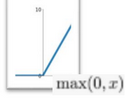

In [17]:
Image(filename="./img/relu.png")

In [18]:
def ReLU_all(result_conv_norm):
    shapes = result_conv_norm.shape
    res = np.zeros(shapes) # сначала все 0, потом где > 0 будем ставить это значение
    for i in range(shapes[0]):
        for j in range(shapes[1]):
            for k in range(shapes[2]):
                if result_conv_norm[i][j][k] > 0: res[i][j][k] = result_conv_norm[i][j][k]
    return res

In [19]:
result_conv_norm_relu = ReLU_all(result_conv_norm)
print_res(result_conv_norm_relu)

m=0; shape=(324, 576)
[[0.70248344 0.79513977 0.85269603 ... 0.         0.         0.        ]
 [0.92158539 0.94311291 0.92323642 ... 0.         0.         0.        ]
 [0.97485995 0.93817826 0.90754569 ... 0.         0.         0.        ]
 ...
 [1.78516711 1.75465749 1.67494049 ... 0.10173609 0.09584226 0.16858712]
 [0.08641814 0.05453611 0.01366673 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
m=1; shape=(324, 576)
[[0.74026572 0.85439783 0.93132781 ... 0.         0.         0.        ]
 [1.02146534 1.06925293 1.06431971 ... 0.         0.         0.        ]
 [1.11823439 1.0814835  1.04288711 ... 0.         0.         0.        ]
 ...
 [1.75334199 1.72294205 1.65923217 ... 0.15448154 0.16181298 0.19033433]
 [0.71614322 0.68423365 0.63400821 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
m=2; shape=(324, 576)
[[0.57940092 0.68484002 0.75498136 ... 0.     

## 4. Max pooling 2x2   
Сверточных слоев в сети может быть много. Если на предыдущей операции свертки уже   
были выявлены некоторые признаки, то для дальнейшей обработки настолько подробное изображение уже не нужно.   
Нужно сжать изображение в 2 раза   
Пройтись окном и выбрать в нем макс -> значение в сжатом изображении   

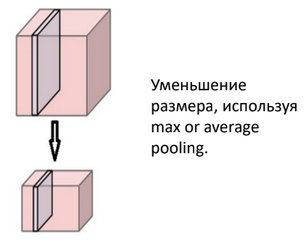

In [20]:
Image(filename="img/pooling.png")

In [21]:
def max_pooling_2x2(img):
    p = 2
    src_shape = img.shape
    new_shape = (src_shape[0], src_shape[1] // p, src_shape[2] // p) # картинка уменьшается в 2 раза
    res = np.zeros(new_shape) 
    for i in range(new_shape[0]):
        for j in range(new_shape[1]):
            for k in range(new_shape[2]):
                left_x = p*j
                right_x = p*j+p
                top_y = p*k
                bot_y = p*k+p
                # выйти за границы здесь невозможно, т.к. идем по новой картинке
                # окно из граничной точки новой является последним окном в старой
                # т.е правая и(или) нижняя границы окна совпадут с границами старой картинки
                window = img[i, left_x:right_x, top_y:bot_y] # окно 2x2
                res[i][j][k] = np.max(window)

    return res

In [22]:
result_conv_norm_relu_maxpooling = max_pooling_2x2(result_conv_norm_relu)

In [23]:
result_conv_norm_relu.shape

(5, 324, 576)

In [24]:
result_conv_norm_relu_maxpooling.shape

(5, 162, 288)

In [25]:
result_conv_norm_relu[0,0:4,0:4],

(array([[0.70248344, 0.79513977, 0.85269603, 0.87569803],
        [0.92158539, 0.94311291, 0.92323642, 0.90985617],
        [0.97485995, 0.93817826, 0.90754569, 0.89533172],
        [0.95932038, 0.92919074, 0.90320858, 0.89035024]]),)

In [26]:
result_conv_norm_relu_maxpooling[0,0:2,0:2]

array([[0.94311291, 0.92323642],
       [0.97485995, 0.90754569]])

In [27]:
print_res(result_conv_norm_relu_maxpooling)

m=0; shape=(162, 288)
[[0.94311291 0.92323642 0.89650237 ... 0.         0.         0.        ]
 [0.97485995 0.90754569 0.88143166 ... 0.         0.         0.        ]
 [0.95189109 0.9006036  0.87178016 ... 0.         0.         0.        ]
 ...
 [1.77186332 1.6942612  1.72039771 ... 0.07711747 0.1074378  0.1773315 ]
 [1.78516711 1.68194864 1.60649626 ... 0.06592921 0.10173609 0.16858712]
 [0.08641814 0.01366673 0.         ... 0.         0.         0.        ]]
m=1; shape=(162, 288)
[[1.06925293 1.06431971 1.04712155 ... 0.         0.         0.        ]
 [1.11823439 1.04288711 1.01967421 ... 0.         0.         0.        ]
 [1.08599767 1.03178246 1.01065015 ... 0.         0.         0.        ]
 ...
 [1.74252075 1.66917487 1.68929044 ... 0.13735913 0.16275206 0.19952097]
 [1.75334199 1.66022356 1.586765   ... 0.12528094 0.15448154 0.19033433]
 [0.71614322 0.63400821 0.51201399 ... 0.         0.         0.        ]]
m=2; shape=(162, 288)
[[0.88745519 0.88768333 0.85821196 ... 0.     

## 5. SoftMax   
Softmax преобразует значения в относительные вероятности, в сумме 1

In [28]:
def calc_exps_sum(img):
    shapes = img.shape
    exps = np.zeros(shapes[0])
    for i in range(shapes[0]):
        for j in range(shapes[1]):
            for k in range(shapes[2]):
                exps[i] += exp(img[i][j][k])
    return exps

def softmax(img):
    shapes = img.shape
    res = np.zeros(shapes)
    exps_sum = calc_exps_sum(img)

    for i in range(shapes[0]):
        for j in range(shapes[1]):
            for k in range(shapes[2]):
                res[i][j][k] = exp(img[i][j][k]) / exps_sum[i]
    return res

In [29]:
result_conv_norm_relu_maxpooling_softmax = softmax(result_conv_norm_relu_maxpooling)

In [30]:
result_conv_norm_relu_maxpooling_softmax[0,0:2,0:2]

array([[2.54350554e-05, 2.49344870e-05],
       [2.62554974e-05, 2.45463001e-05]])

In [31]:
result_conv_norm_relu_maxpooling_softmax.shape

(5, 162, 288)

In [32]:
print_res(result_conv_norm_relu_maxpooling_softmax)

m=0; shape=(162, 288)
[[2.54350554e-05 2.49344870e-05 2.42767187e-05 ... 9.90475998e-06
  9.90475998e-06 9.90475998e-06]
 [2.62554974e-05 2.45463001e-05 2.39135945e-05 ... 9.90475998e-06
  9.90475998e-06 9.90475998e-06]
 [2.56593117e-05 2.43764877e-05 2.36839028e-05 ... 9.90475998e-06
  9.90475998e-06 9.90475998e-06]
 ...
 [5.82578455e-05 5.39078793e-05 5.53354171e-05 ... 1.06988143e-05
  1.10281738e-05 1.18265494e-05]
 [5.90380740e-05 5.32482047e-05 4.93783323e-05 ... 1.05797802e-05
  1.09654732e-05 1.17235843e-05]
 [1.07987846e-05 1.00410549e-05 9.90475998e-06 ... 9.90475998e-06
  9.90475998e-06 9.90475998e-06]]
m=1; shape=(162, 288)
[[2.88321285e-05 2.86902436e-05 2.82010428e-05 ... 9.89705671e-06
  9.89705671e-06 9.89705671e-06]
 [3.02795267e-05 2.80818798e-05 2.74375255e-05 ... 9.89705671e-06
  9.89705671e-06 9.89705671e-06]
 [2.93189797e-05 2.77717654e-05 2.71910413e-05 ... 9.89705671e-06
  9.89705671e-06 9.89705671e-06]
 ...
 [5.65292475e-05 5.25314626e-05 5.35988629e-05 ... 1.1

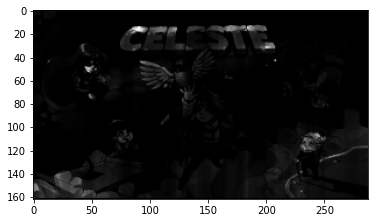

In [33]:
plt.imshow(result_conv_norm_relu_maxpooling_softmax[0], cmap='gray')

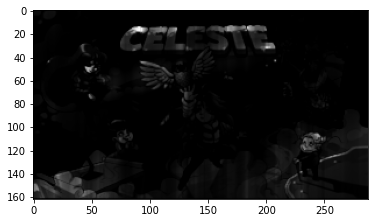

In [34]:
plt.imshow(result_conv_norm_relu_maxpooling_softmax[1], cmap='gray')

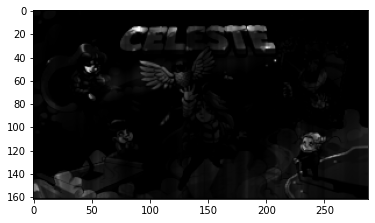

In [35]:
plt.imshow(result_conv_norm_relu_maxpooling_softmax[2], cmap='gray')

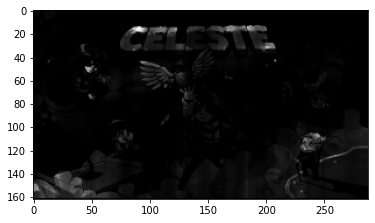

In [36]:
plt.imshow(result_conv_norm_relu_maxpooling_softmax[3], cmap='gray')

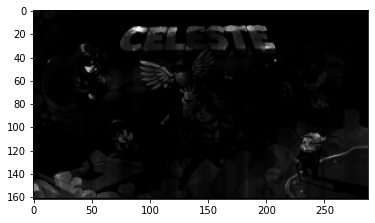

In [37]:
plt.imshow(result_conv_norm_relu_maxpooling_softmax[4], cmap='gray')

Получили 5 изображений, готовых к следующему слою

(если что они немного отличаются)